# Example 5 - REINFORCE

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE

from utils.plotting import plot_trained_trajectories

### Initialize Vanilla RNN

The `RNNparams` object stores the parameters, and is passed to the RNN

Note that we do not have any driving feedback

In [3]:
params = RNNparams(n_in=2, n_rec=5,n_out=2,tau_rec=10,
                   eta_in=0.1,eta_rec=0.1,eta_out=0.1,
                   sig_in=0.0,sig_rec=0.0,sig_out=0.01,
                   rng=np.random.RandomState(14))

print('\nannotations',params.__annotations__)
print('\nparams as dict',dataclasses.asdict(params))

net = RNN(params)
net.initialize_weights()
print('\nrecurrent weights',net.w_rec)


annotations {'n_in': <class 'int'>, 'n_rec': <class 'int'>, 'n_out': <class 'int'>, 'sig_in': <class 'float'>, 'sig_rec': <class 'float'>, 'sig_out': <class 'float'>, 'tau_rec': <class 'float'>, 'eta_in': typing.Union[float, NoneType], 'eta_rec': typing.Union[float, NoneType], 'eta_out': typing.Union[float, NoneType], 'driving_feedback': <class 'bool'>, 'eta_fb': typing.Union[float, NoneType], 'sig_fb': typing.Union[float, NoneType], 'feedback_signal': typing.Union[str, NoneType], 'velocity_transform': <class 'bool'>, 'tau_vel': typing.Union[float, NoneType], 'dt_vel': typing.Union[float, NoneType], 'rng': <mtrand.RandomState object at 0x7fd67e81dab0>}

params as dict {'n_in': 2, 'n_rec': 5, 'n_out': 2, 'sig_in': 0.0, 'sig_rec': 0.0, 'sig_out': 0.01, 'tau_rec': 10, 'eta_in': 0.1, 'eta_rec': 0.1, 'eta_out': 0.1, 'driving_feedback': False, 'eta_fb': None, 'sig_fb': None, 'feedback_signal': 'position', 'velocity_transform': False, 'tau_vel': None, 'dt_vel': None, 'rng': <mtrand.RandomSta

### Create an example Task

Here the task is simply to reach the target at (1,1) given a pulse of trial 20 steps that lasts for 50% of the trial duration (i.e. 10 steps)

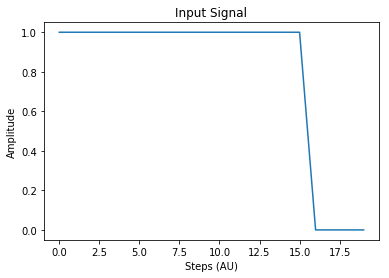

trial duration = 20


In [4]:
trial_duration = 20
n_in=1
frac_on = 0.8
y_target_x = np.expand_dims(np.concatenate((np.zeros(int(trial_duration*frac_on)),np.linspace(0,1,int(trial_duration*(1-frac_on))))),axis=1)
y_target_y = np.expand_dims(np.concatenate((np.zeros(int(trial_duration*frac_on)),np.linspace(0,1,int(trial_duration*(1-frac_on))))),axis=1)
y_teaching_signal = np.concatenate((y_target_x,y_target_y),axis=1)

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1

plt.plot(x_pulse1)
plt.title('Input Signal')
plt.xlabel('Steps (AU)')
plt.ylabel('Amplitude')
plt.show()

task = Task(x_in=x_pulse1,y_target=np.asarray([1,1]))
print('trial duration =',task.trial_duration)

### Train an RNN on a single target using REINFORCE

Note here that we are only learning the recurrent weights `w_rec`

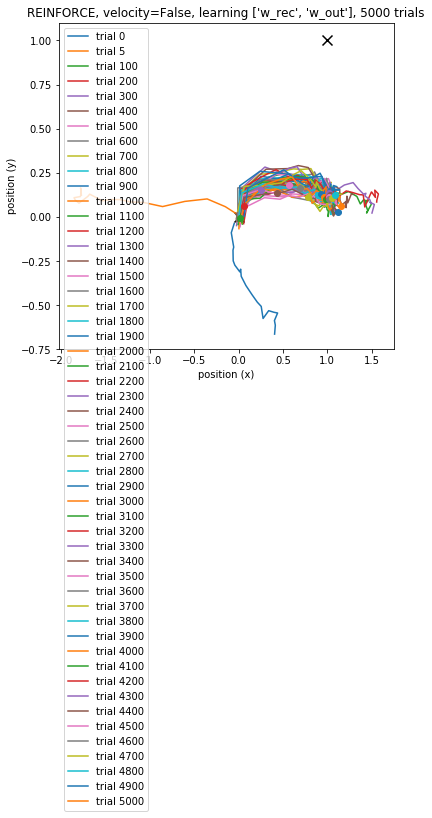

In [8]:

# Set RNN Parameters
params = RNNparams(n_in=1,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.025,eta_out=0.1,
               sig_in=0.01,sig_rec=0.1,sig_out=0.01,
               velocity_transform=False,
               rng=np.random.RandomState(0))

# Initialize RNN
net = RNN(params)

task = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]),y_teaching_signal=y_teaching_signal)

# initialize simulation
sim = Simulation(net)

""" Instantiate learning algorithm """
# Specify particular matrix/unit to apply algorithm
reinforce = REINFORCE(net,apply_to=['w_rec'],online=False,sig_xi=1,tau_reward=20) 
rflo = RFLO(net,apply_to=['w_rec','w_out']) 

plt.figure(figsize=(6,6))

for i in range(5001):
    
    if i < 1:
        sim.run_trial(task,learn_alg=[rflo],probe_types=['h','y_out','pos'],train=True)
        #plt.plot(sim.probes['pos'].squeeze()[:,0],sim.probes['pos'].squeeze()[:,1],label='trial {}'.format(i))

    else:
        sim.run_trial(task,learn_alg=[reinforce],probe_types=['h','y_out','pos'],train=True)
    
    if i % 100 == 0 or i == 5:
        plt.plot(sim.probes['pos'].squeeze()[:,0],sim.probes['pos'].squeeze()[:,1],label='trial {}'.format(i))
    
sim.run_trial(task,probe_types=['h','pos'],train=False)


plt.plot([sim.probes['pos'].squeeze()[:,0]],[sim.probes['pos'].squeeze()[:,1]],'o')
plt.title('REINFORCE, velocity={}, learning {}, {} trials'.format(net.velocity_transform,rflo.apply_to,i))
plt.scatter(task.y_target[0,:],task.y_target[1,:],s=100,marker='x',color='k')
plt.scatter(0,0,s=100,marker='x',color='k')
# plt.xlim(-1.5,1.5)
# plt.ylim(-1.5,1.5)
plt.xlabel('position (x)')
plt.ylabel('position (y)')
plt.legend()
plt.show()

### Train RNN on four targets using REINFORCE

In [19]:
trial_duration = 20
n_in=4
frac_on = 0.4

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
# changing input can help...a bit
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = -1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

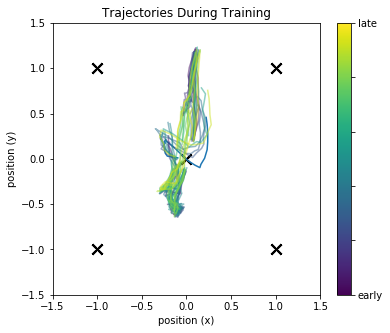

In [20]:
# Set RNN Parameters
# eta rec 0.1, 0.025
#sig_rec 0.1, 0.05
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.025,eta_out=0.1,
               sig_in=0.01,sig_rec=0.05,sig_out=0.01,
               velocity_transform=False,
               rng=np.random.RandomState(0))

# Initialize RNN
net = RNN(params)


# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
reinforce = REINFORCE(net,apply_to=['w_rec'],online=False,sig_xi=1,tau_reward=20) 
rflo = RFLO(net,apply_to=['w_in','w_rec','w_out'],online=True) 

# SOMETHIHNG IS STRANGE HERE -  SOMETHHING IS WRONG WITHH ALGO regardless of online=False or True...eventually ends up at same target?


#sim.run_session(n_trials=1, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=1)

sim.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','y_out','pos'], plot=True, plot_freq=100)


We can also plot the trained trajectories

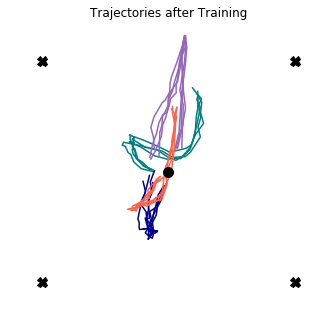

In [21]:
fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4])


In [44]:
x_pulse2

array([[ 0., -5.,  0.,  0.],
       [ 0., -5.,  0.,  0.],
       [ 0., -5.,  0.,  0.],
       [ 0., -5.,  0.,  0.],
       [ 0., -5.,  0.,  0.],
       [ 0., -5.,  0.,  0.],
       [ 0., -5.,  0.,  0.],
       [ 0., -5.,  0.,  0.],
       [ 0., -5.,  0.,  0.],
       [ 0., -5.,  0.,  0.],
       [ 0., -5.,  0.,  0.],
       [ 0., -5.,  0.,  0.],
       [ 0., -5.,  0.,  0.],
       [ 0., -5.,  0.,  0.],
       [ 0., -5.,  0.,  0.],
       [ 0., -5.,  0.,  0.],
       [ 0., -5.,  0.,  0.],
       [ 0., -5.,  0.,  0.],
       [ 0., -5.,  0.,  0.],
       [ 0., -5.,  0.,  0.]])